In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 123

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


In [3]:
workers = 2
# Batch size
batch_size = 128

# Size of image
image_size = 32

# Number of channels
channels = 3

# Size of generator input
nz = 100

# Size of feature maps in generator
g_ftrs = 32

# Size of feature maps in discriminator
d_ftrs = 32


In [2]:
# Function to load dataset
import numpy as np
from matplotlib import image as img
import glob
def loadDataset(path):
    print(path)
    #              0            1         2     3      4     5      6      7      8       9  
    classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):
        for filename in glob.glob(path + '/train/train/' + classes[i]+'/*.png'):
            im=img.imread(filename)
            train_x.append(im)
            train_y.append(i)
    for i in range(10):
        for filename in glob.glob(path + '/test/test/' + classes[i]+'/*.png'):
            im=img.imread(filename)
            test_x.append(im)
            test_y.append(i)
    print('Dataset loaded...')
    return np.array(train_x), np.array(train_y),np.array(test_x),np.array(test_y)

In [4]:
wd_path = os.getcwd()
data_path = '/Data/'
dataroot = wd_path+data_path
print(dataroot)

/media/cactus/4e67278b-3e94-475f-94e3-ff8e3b0f8973/shahab/DeepLearningAssignments/Assignment4/Data/


In [5]:
trainX, trainY, testX,testY = loadDataset(dataroot)
trainX.shape

/media/cactus/4e67278b-3e94-475f-94e3-ff8e3b0f8973/shahab/DeepLearningAssignments/Assignment4/Data/
Loading Dataset...
Dataset loaded...


(50000, 32, 32, 3)

In [6]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data,targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.data[index]
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
dataset = MyDataset(trainX, trainY, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

torch.Size([128, 3, 32, 32])


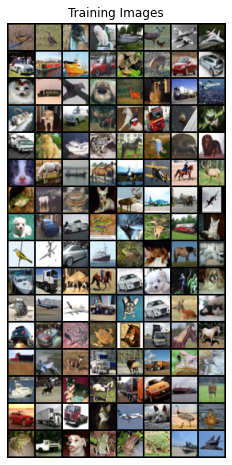

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() ) else "cpu")
real_batch = next(iter(dataloader))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Generator 
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(nz,128*4*4)
        )
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #nn.ConvTranspose2d( nz, g_ftrs * 4, 4, 1, 0, bias=False),
            
            
            nn.BatchNorm2d(g_ftrs * 4),
            nn.ReLU(True),
            # state size. (g_ftrs*8) x 4 x 4
            nn.ConvTranspose2d(g_ftrs * 4, g_ftrs * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_ftrs * 2),
            nn.ReLU(True),
            # state size. (g_ftrs*4) x 8 x 8
            nn.ConvTranspose2d( g_ftrs * 2, g_ftrs , 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_ftrs ),
            nn.ReLU(True),
            # state size. (g_ftrs*2) x 16 x 16
            nn.ConvTranspose2d( g_ftrs, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (channels) x 32 x 32
        )

    def forward(self, input):
        N = input.shape[0]
        x=self.linear(input)
        x=torch.reshape(x, (N,128, 4, 4))
        return self.main(x)

In [10]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
  )
  (main): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Tanh()
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (channels) x 32 x 32
            nn.Conv2d(channels, d_ftrs , 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_ftrs ),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d_ftrs*2) x 16 x 16
            nn.Conv2d(d_ftrs , d_ftrs * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_ftrs * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d_ftrs*4) x 8 x 8
            nn.Conv2d(d_ftrs * 2, d_ftrs * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_ftrs * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (d_ftrs*8) x 4 x 4
            nn.Conv2d(d_ftrs * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
lr = 0.00008
#lr = 0.00008
beta1 = 0.5
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/391]	Loss_D: 1.3201	Loss_G: 0.8862	D(x): 0.6003	D(G(z)): 0.5207 / 0.4358
[0/10][50/391]	Loss_D: 0.7385	Loss_G: 1.5660	D(x): 0.7249	D(G(z)): 0.3151 / 0.2292
[0/10][100/391]	Loss_D: 0.3742	Loss_G: 2.2951	D(x): 0.8408	D(G(z)): 0.1720 / 0.1115
[0/10][150/391]	Loss_D: 0.3023	Loss_G: 2.8025	D(x): 0.8680	D(G(z)): 0.1362 / 0.0710
[0/10][200/391]	Loss_D: 0.2039	Loss_G: 3.2458	D(x): 0.9167	D(G(z)): 0.1041 / 0.0521
[0/10][250/391]	Loss_D: 0.2584	Loss_G: 2.7374	D(x): 0.8915	D(G(z)): 0.1241 / 0.0814
[0/10][300/391]	Loss_D: 0.3661	Loss_G: 3.2225	D(x): 0.8851	D(G(z)): 0.1879 / 0.0508
[0/10][350/391]	Loss_D: 0.1980	Loss_G: 3.4523	D(x): 0.9235	D(G(z)): 0.1034 / 0.0403
[1/10][0/391]	Loss_D: 0.1660	Loss_G: 3.6322	D(x): 0.9147	D(G(z)): 0.0652 / 0.0335
[1/10][50/391]	Loss_D: 0.1277	Loss_G: 3.7009	D(x): 0.9382	D(G(z)): 0.0563 / 0.0294
[1/10][100/391]	Loss_D: 0.1068	Loss_G: 3.9527	D(x): 0.9570	D(G(z)): 0.0582 / 0.0253
[1/10][150/391]	Loss_D: 0.4381	Loss_G: 2.6928	D(x): 0.89

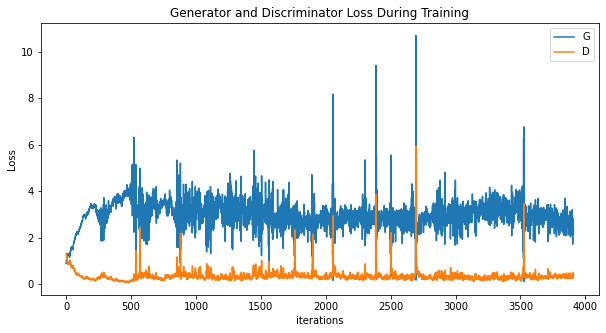

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

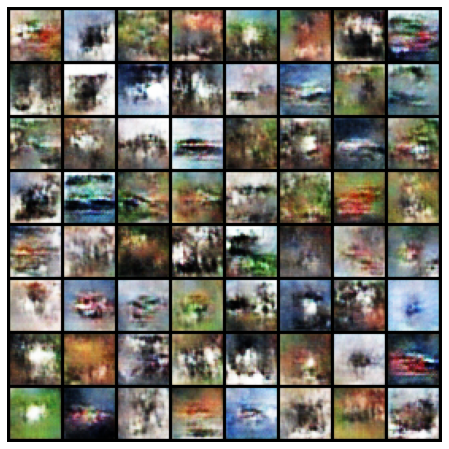

In [17]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

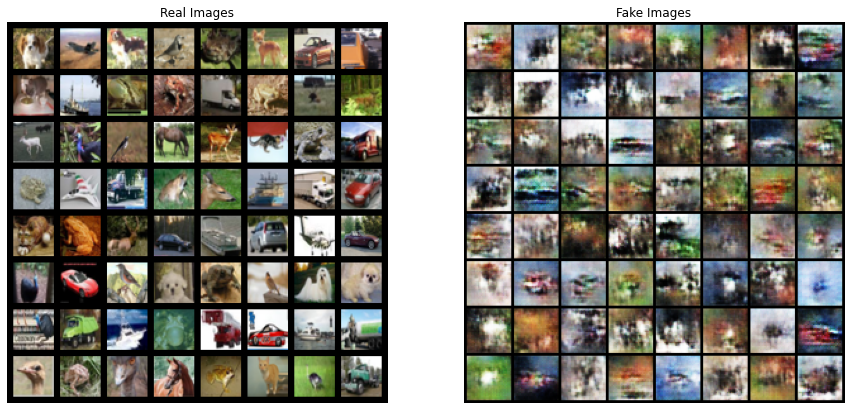

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [38]:
torch.save(netG.state_dict(), 'fcG_50epoch.pth' )
torch.save(netD.state_dict(), 'fcD_50epoch.pth' )

In [ ]:
ngpu = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG = Generator(ngpu).to(device)
#netG = torch.load('weightsnetG_100epoch.pth')
netG.load_state_dict(torch.load('weightsnetG_Cars300epoch.pth'))


In [ ]:



test_noise = torch.randn(64, nz, 1, 1, device=device)
img_list_test=[]
with torch.no_grad():
    fake = netG(test_noise).detach().cpu()
img_list_test.append(vutils.make_grid(fake, padding=2, normalize=True))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list_test[-1],(1,2,0)))
plt.show()
